<a href="https://colab.research.google.com/github/ghizlanebo/nltk/blob/main/r_lda_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyldavis


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

init_notebook_mode(connected=True) #do not miss this line

import warnings
warnings.filterwarnings("ignore")

In [4]:
import pyLDAvis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [5]:
datafile = "/content/drive/MyDrive/REC_CG_19-21.xlsx"

In [6]:
pip install openpyxl==2.6.0

     |████████████████████████████████| 174kB 4.0MB/s 
  Created wheel for openpyxl: filename=openpyxl-2.6.0-py2.py3-none-any.whl size=243902 sha256=b3f2dc9ee452c62f1fc5e299795f8d5cb2d870678ff2a8796d4c03f718f313f6
  Stored in directory: /root/.cache/pip/wheels/5a/de/77/f07186146bd0337342dd8c86fa12441f4f9c59573c51dcce9d
Successfully built openpyxl
  Found existing installation: openpyxl 2.5.9
    Uninstalling openpyxl-2.5.9:
      Successfully uninstalled openpyxl-2.5.9


In [7]:
import pandas as pd
df = pd.read_excel(datafile)




/usr/local/lib/python3.7/dist-packages/openpyxl/xml/functions.py:30: DeprecationWarning:

defusedxml.cElementTree is deprecated, import from defusedxml.ElementTree instead.

/usr/local/lib/python3.7/dist-packages/openpyxl/xml/functions.py:31: DeprecationWarning:

defusedxml.lxml is no longer supported and will be removed in a future release.



In [8]:
print("Nombres de demandes: ",len(df['descri']))
df.head(5)

Nombres de demandes:  379119


,Rec_DateEnvoi,Rec_Id,Typeaccueil,MotifTypeLibFr,Motif_Lib,Rec_EtatType_Lib,Rec_DateEtat,descri
0,2019-01-21 14:27:00,1,Visite,Réclamation,Remises en paiement,Traité,2019-06-17 16:29:00,- Concerné(s): MOHAMED & OUMAIMA - Situation...
1,2020-05-29 10:37:00,2,Téléphone,Demande de renseignement,Allocations Familiales,Traité,2020-05-29 10:44:00,L’intéressé a réclame date de naissance de en...
2,2019-11-27 11:07:00,3,Téléphone,Demande de renseignement,Précomptes,Traité,2019-11-27 11:08:00,"672,00DH] [ATD DEFENSE"
3,2020-12-08 10:12:00,4,Visite,Nonaffiché,Autre,Traité,2020-12-08 10:12:00,Attestation pension
4,2020-12-08 10:08:00,5,Téléphone,Demande de renseignement,Pension principale,Traité,2020-12-08 10:11:00,"RAPPEL : [ 9018,52DH] [PREMIER ARRERAGE"


In [ ]:
'''import plotly.plotly as py
import plotly.graph_objs as go
'''
df['Rec_DateEnvoi'] = pd.to_datetime(df['Rec_DateEnvoi'], format='%y-%m-%d %H:%M:%S')
dataT = df['Rec_DateEnvoi']

trace = go.Histogram(
    x=dataT,
    marker=dict(
        color='blue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='Réclamation au cous du temps',
    height=450,
    width=1200,
    xaxis=dict(
        title='Mois et année'
    ),
    yaxis=dict(
        title='Nombre de réclamtion'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [9]:

corpus=[]
a=[]
for i in range(len(df['descri'])):
        a=df['descri'][i]
        corpus.append(a)
        
corpus[0:10]

['- Concerné(s): MOHAMED & OUMAIMA   - Situation : Non remis en paiement   - Dossier de recherche: Dossier de compagne de controle de maintien de droit   - Clé de recherche: N° Pension   - Délai de retard:   - Réclamations répétitives: Oui  N.B: Scanné/GED Sous Réf N° 1594/18 et affecté le 11/12/2018.',
 'L’intéressé  a réclame date de naissance de enfant  safae erroné.',
 '672,00DH] [ATD DEFENSE',
 'Attestation pension',
 'RAPPEL : [ 9018,52DH] [PREMIER ARRERAGE',
 'aucun',
 'Dde d’info .',
 'RET : [    223,52DH] [ Prec. Prets',
 'DIVORCE',
 'Etat..........: V  Demande validée']

In [10]:
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


Folder "/tmp" will be used to save temporary dictionary and corpus.


In [19]:
# removing common words and tokenizing
list1 = ['cmr','bonjour','merci','comme', 'si', 'faire', 'cette', 'aussi', 'ainsi', 'toutes','beaucoup', 'faut', 'falloir',
              'cela', 'va', 'aller', 'là', 'ça','peux', 'pouvoir', 'quand', 'encore', 'donc', 'toujours', 
              'où','quelques', 'autre', 'autres', 'alors', 'entre', 'car', 'après','avant','depuis', 'également', 'un','trois', 'quatre', 'avoir', 'bon', 
              'première', 'premier','deuxième', 'niveau', 'face', 'contre', 'journée', 'début','jours', 
              'journée', 'année', 'jamais', 'lu', 'lire','selon', 'hui', 'aujourd', 'grand','dire', 'dit',
              'dis', 'cet','cette','nouveau','nouvelle','mis','mettre','chez','1','2','3','4','5','6','7','8','9','0',']','[','(',')','#','$',',',':','/','B.C.P','&','dde','ddr','NaN','nan','a','non',"d'",'03/03/2021/',
 '08/04/2021,','08:03:21','08:35:37','10/10/2019,','10:18:57','11994.23','13577.38','13973.','13:05:02','14021.68','16:16:08','1990,35dh][','297905',
 '30862,14dh]',
 '592110076',
 '7140086/111',
 '7182690',
 '7293108',
 '7303271/312',
 '7303271/313',
 '9397.47',
 '[nais.rajaa',
 ']&#9474;[20/03/2000]',
 'aafecte',
 'augment',
 'b.c.p.',
 'cpc',
 'elhamdounifatima8@gmail.com',
 'jed!',"l'",'aucun','ctrl','réc','rec','rev','cs','n°','réf','01/02/2020','cdt','prière','bonjour','cordialement','&#9474;date','11/02/2020','11/12/2019','2019','2020','2021','2016','2015','2017','2016','2018','rcar','el']

In [20]:
import nltk
nltk.download('stopwords')
stoplist = stopwords.words('french') + list(punctuation) + list1

texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
from collections import Counter
cnt = Counter()
for text in texts:
    for word in text:
        cnt[word] += 1
        
cnt.most_common(10)


[('dossier', 76606),
 ('pension', 40679),
 ('demande', 36937),
 ('recherche', 22697),
 ('clé', 20611),
 ('d’infos', 20186),
 ('documents', 18643),
 ('mois', 18088),
 ('délai', 17250),
 ('ged', 17137)]

In [18]:
n_rare_words = 30
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
RAREWORDS

{'03/03/2021/',
 '08/04/2021,',
 '08:03:21',
 '08:35:37',
 '10/10/2019,',
 '10:18:57',
 '11994.23',
 '13577.38',
 '13973.',
 '13:05:02',
 '14021.68',
 '16:16:08',
 '1990,35dh][',
 '297905',
 '30862,14dh]',
 '592110076',
 '7140086/111',
 '7182690',
 '7293108',
 '7303271/312',
 '7303271/313',
 '9397.47',
 '[nais.rajaa',
 ']&#9474;[20/03/2000]',
 'aafecte',
 'augment',
 'b.c.p.',
 'cpc',
 'elhamdounifatima8@gmail.com',
 'jed!'}

In [21]:

dictionary = corpora.Dictionary(texts)

2021-06-09 14:23:30,101 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-06-09 14:23:30,235 : INFO : adding document #10000 to Dictionary(8462 unique tokens: ['11/12/2018.', '1594/18', 'affecté', 'clé', 'compagne']...)
2021-06-09 14:23:30,362 : INFO : adding document #20000 to Dictionary(13264 unique tokens: ['11/12/2018.', '1594/18', 'affecté', 'clé', 'compagne']...)
2021-06-09 14:23:30,497 : INFO : adding document #30000 to Dictionary(17981 unique tokens: ['11/12/2018.', '1594/18', 'affecté', 'clé', 'compagne']...)
2021-06-09 14:23:30,650 : INFO : adding document #40000 to Dictionary(21977 unique tokens: ['11/12/2018.', '1594/18', 'affecté', 'clé', 'compagne']...)
2021-06-09 14:23:30,796 : INFO : adding document #50000 to Dictionary(25925 unique tokens: ['11/12/2018.', '1594/18', 'affecté', 'clé', 'compagne']...)
2021-06-09 14:23:30,938 : INFO : adding document #60000 to Dictionary(29646 unique tokens: ['11/12/2018.', '1594/18', 'affecté', 'clé', 'compagne']...)
20

In [22]:
dictionary.save(os.path.join(TEMP_FOLDER, 'reclam.dict'))  # store the dictionary, for future reference



2021-06-09 14:23:41,067 : INFO : saving Dictionary object under /tmp/reclam.dict, separately None
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning:

This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information

2021-06-09 14:23:41,128 : INFO : saved /tmp/reclam.dict


In [23]:

corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'reclam.mm'), corpus)  # store to disk, for later use


2021-06-09 14:23:49,410 : INFO : storing corpus in Matrix Market format to /tmp/reclam.mm
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning:

This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information

2021-06-09 14:23:49,414 : INFO : saving sparse matrix to /tmp/reclam.mm
2021-06-09 14:23:49,417 : INFO : PROGRESS: saving document #0
2021-06-09 14:23:49,431 : INFO : PROGRESS: saving document #1000
2021-06-09 14:23:49,446 : INFO : PROGRESS: saving document #2000
2021-06-09 14:23:49,462 : INFO : PROGRESS: saving document #3000
2021-06-09 14:23:49,476 : INFO : PROGRESS: saving document #4000
2021-06-09 14:23:49,491 : INFO : PROGRESS: saving document #5000
2021-06-09 14:23:49,504 : INFO : PROGRESS: saving document #6000
2021-06-09 14:23:49,518 : INFO : PROGRESS: saving document #7000
2021-06-09 14:23:49,532 : INFO : PROGRESS: saving document #8000
2021-06-09 

Dans les cellules précédentes, j'ai créé un corpus de documents représentés comme un flux de vecteurs. Pour continuer, utilisons ce corpus, avec l'aide de Gensim.



Les transformations sont des objets Python standard, typiquement initialisés au moyen d'un corpus d'entraînement :

Différentes transformations peuvent nécessiter différents paramètres d'initialisation ; dans le cas de TfIdf, le "training" consiste simplement à parcourir une fois le corpus fourni et à calculer les fréquences des documents de toutes ses caractéristiques. 



In [24]:
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model

2021-06-09 14:24:05,062 : INFO : collecting document frequencies
2021-06-09 14:24:05,064 : INFO : PROGRESS: processing document #0
2021-06-09 14:24:05,089 : INFO : PROGRESS: processing document #10000
2021-06-09 14:24:05,106 : INFO : PROGRESS: processing document #20000
2021-06-09 14:24:05,130 : INFO : PROGRESS: processing document #30000
2021-06-09 14:24:05,154 : INFO : PROGRESS: processing document #40000
2021-06-09 14:24:05,177 : INFO : PROGRESS: processing document #50000
2021-06-09 14:24:05,198 : INFO : PROGRESS: processing document #60000
2021-06-09 14:24:05,219 : INFO : PROGRESS: processing document #70000
2021-06-09 14:24:05,235 : INFO : PROGRESS: processing document #80000
2021-06-09 14:24:05,257 : INFO : PROGRESS: processing document #90000
2021-06-09 14:24:05,278 : INFO : PROGRESS: processing document #100000
2021-06-09 14:24:05,293 : INFO : PROGRESS: processing document #110000
2021-06-09 14:24:05,313 : INFO : PROGRESS: processing document #120000
2021-06-09 14:24:05,330 : 

In [25]:
corpus_tfidf = tfidf[corpus] 

In [26]:
total_topics = 14

In [27]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/l

In [28]:
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi


In [29]:
#Show first n important word in the topics:
lda.show_topics(total_topics,14)

[(0,
  '0.082*"rappel" + 0.068*"dépôt" + 0.062*"[revision" + 0.057*"radiation" + 0.047*"rap" + 0.046*"suspension" + 0.043*"[arret" + 0.038*"certificat" + 0.030*"percu" + 0.028*"décès" + 0.028*"[trop" + 0.027*"vm" + 0.022*"remp-2-ech" + 0.013*"af"'),
 (1,
  '0.164*"pension" + 0.142*"d’info" + 0.082*"d’information" + 0.077*"attestation" + 0.070*"délivré" + 0.030*"cour" + 0.024*"l’" + 0.023*"intéresse" + 0.017*"rcar:" + 0.016*"liste:" + 0.015*"n°d’affiliation" + 0.009*"coti" + 0.009*"certifie" + 0.009*"récla"'),
 (2,
  '0.117*"pension" + 0.094*"remise" + 0.040*"l’intéresse" + 0.038*"paiement" + 0.035*"cs" + 0.031*"infos." + 0.030*"n°" + 0.022*"affecté" + 0.020*"scolarité" + 0.015*"06/09/2019" + 0.013*"commission" + 0.013*"cdt" + 0.013*"prière" + 0.013*"controle"'),
 (3,
  '0.311*"demande" + 0.096*"d’infos" + 0.066*"date" + 0.022*"info" + 0.017*"l’intéressée" + 0.016*"cin" + 0.014*"voir" + 0.013*"v" + 0.013*"validée" + 0.013*"virement" + 0.012*"dd" + 0.008*"rectification" + 0.008*"procurat

In [30]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}


In [31]:
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(14, 325)


In [32]:
df_lda


,rappel,dépôt,[revision,radiation,rap,suspension,[arret,certificat,percu,décès,[trop,vm,remp-2-ech,af,2018/2019,acte,déjà,copie,cin,cnrm,l’enfant,2019/2020,deux,suppression,vrg,pension,d’info,d’information,attestation,délivré,cour,l’,intéresse,rcar:,liste:,n°d’affiliation,coti,certifie,récla,21,...,rejet,[prec.,retenue,montant,m-6,fonda,renseignement.,[divorce,concede,dépot,précompte,svp,savoir,enfants,net:,erroné,probleme,inf,réclamation,affectée,cours,cert,parvenu,11/02/2020,concedé,révision,encours,reversion,....:,réc,recu,liquidé,reclamation,limite,cv,d’âge,lien,motif,complément,affectee
0,0.081824,0.068299,0.062151,0.056859,0.047445,0.046077,0.043484,0.038127,0.029691,0.028463,0.027685,0.027308,0.021808,0.012628,0.010335,0.01003,0.008838,0.00687,0.006464,0.004901,0.004686,0.004338,0.004029,0.003622,0.003481,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.164072,0.142085,0.082479,0.07741,0.070454,0.029804,0.023977,0.022908,0.017179,0.015727,0.015092,0.008908,0.008877,0.0088,0.008225,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.117382,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.015850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

2021-06-09 14:27:02,787 : INFO : NumExpr defaulting to 2 threads.


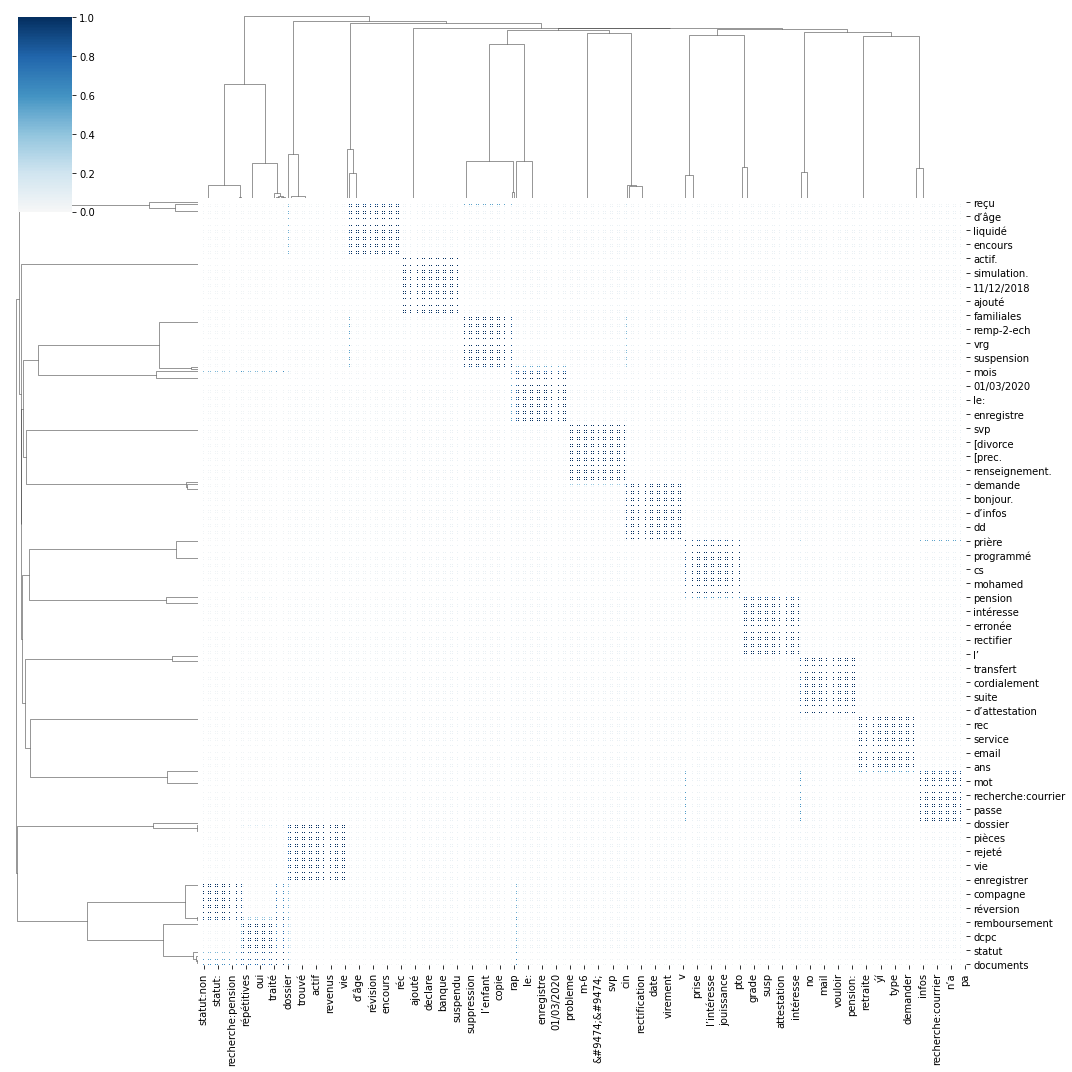

In [33]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [34]:
import pyLDAvis.gensim_models as gensimvis

In [35]:
pyLDAvis.enable_notebook()
panel = gensimvis.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning:

`np.float` is 

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
11       1.425140 -203.131439       1        1  31.100537
2       93.696953  -55.018154       2        1  25.890185
5      141.694016   25.320429       3        1   3.677932
10    -126.233505    5.739788       4        1   3.615710
13     -59.868134  101.519302       5        1   3.571578
4      151.966629  133.119141       6        1   3.571564
1       12.542690 -101.441658       7        1   3.571563
8       49.372585   57.773476       8        1   3.571562
7      203.505997  -84.541840       9        1   3.571562
3      119.923477 -166.068970      10        1   3.571562
6      -19.315592   -8.882428      11        1   3.571562
9      -95.841057 -109.373474      12        1   3.571561
0       37.554749  165.057098      13        1   3.571561
12     243.648911   32.733547      14        1   3.571561, topic_info=           Term          Freq         Total Category  logprob  loglift
17      pension  15119.000000  15119.000000  Default  30.0000  30.0000
7       dossier  13992.000000  13992.000000  Default  29.0000  29.0000
49      demande   5808.000000   5808.000000  Default  28.0000  28.0000
132      remise   9240.000000   9240.000000  Default  27.0000  27.0000
159    suspendu   3422.000000   3422.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
49      demande   1595.596646   5808.715575  Topic14  -2.1384   2.0401
1413     savoir     64.625452     75.042144  Topic14  -5.3448   3.1827
1020  précompte     71.906800     93.619734  Topic14  -5.2380   3.0683
212     enfants     59.453819     86.921167  Topic14  -5.4282   2.9524
843      charge     52.751404    689.841088  Topic14  -5.5478   0.7613

[571 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
598       12  0.998729         &#9474;
5525      14  0.999487  &#9474;&#9474;
29751      5  0.065399     &#9474;date
29751     14  0.934271     &#9474;date
1655      11  0.995683        &agrave;
...      ...       ...             ...
1051      13  0.990591        échéance
366        9  0.998052          éditée
2748       7  0.987150           êõííí
1401      12  1.003669           úáíßã
1459      12  1.002657              ýí

[635 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 3, 6, 11, 14, 5, 2, 9, 8, 4, 7, 10, 1, 13])

* Topic1 : dossier (dépôt, validation,traitement), recherche dans la ged
* Topic2 : etat matrmonial (nouvelle naissance, scolarité)
* Topic3 : Paiement (suspension,remboursement)
* Topic4 : Réversion et vérifcation
* Topic5 : Information sur l'affilation et suivi d'état du dossier
* Topic6 : Réclamtion sur le retard du traitement du dossier de pension
* Topic7 : Vérification de la vie ou décés de l'afillié
* Topic8 : Papier nésessiare (cni, attestation scolarité)
* Topic9 : Révision des informations /dossier
* Topic11 : Demande d'attestation
* Topic12 : Interruption
* Topic13 : Demande d'un rendez-vous
* Topic14 : Changement de la banque (levée la main)


In [36]:
print('\nPerplexity: ', lda.log_perplexity(corpus_lda,total_docs=10000))  # une mesure de la qualité du modèle. Plus elle est faible, mieux c'est..


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/


Perplexity:  -51.69501055854667


In [37]:
from gensim.models.coherencemodel import CoherenceModel


In [ ]:
#texts

In [38]:
coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2021-06-09 14:41:53,992 : INFO : using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-06-09 14:41:54,050 : INFO : WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-06-09 14:41:54,105 : INFO : WordOccurrenceAccumulator accumulated stats from 2000 documents
2021-06-09 14:41:54,156 : INFO : WordOccurrenceAccumulator accumulated stats from 3000 documents
2021-06-09 14:41:54,208 : INFO : WordOccurrenceAccumulator accumulated stats from 4000 documents
2021-06-09 14:41:54,259 : INFO : WordOccurrenceAccumulator accumulated stats from 5000 documents
2021-06-09 14:41:54,310 : INFO : WordOccurrenceAccumulator accumulated stats from 6000 documents
2021-06-09 14:41:54,353 : INFO : WordOccurrenceAccumulator accumulated stats from 7000 documents
2021-06-09 14:41:54,403 : INFO : WordOccurrenceAccumulator accumulated stats from 8000 documents
2021-06-09 14:41:54,462 : INFO : WordOccurrenceAccumulator accumulated stats from 9000 documents
2021-06-09 14:4


Coherence Score:  0.5408297716257034


In [39]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence pour divers nombre de topics

    Paramètres:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Output:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values qui correspond au LDA model avec nombre de topics respectives
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [40]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=2, limit=30, step=1)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/l

In [41]:
def compute_coherence_value(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [44]:
id2word = dictionary


In [47]:
len(corpus)

379119

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
2021-06-09 19:52:26,529 : INFO : topic #8 (0.010): 0.069*"cours" + 0.027*"liquidation" + 0.022*"récla" + 0.020*"certifie" + 0.020*"reclamation" + 0.019*"coti" + 0.013*"infos" + 0.012*"rec" + 0.008*"affecter" + 0.007*"susp"
2021-06-09 19:52:26,537 : INFO : topic #11 (0.010): 0.018*"envoyé" + 0.018*"carte" + 0.016*"passe" + 0.016*"mot" + 0.014*"pièces" + 0.013*"éditée" + 0.008*"l’adresse" + 0.008*"n’est" + 0.007*"l’intéressé" + 0.007*"date"
2021-06-09 19:52:26,545 : INFO : topic #0 (0.010): 0.137*"pension" + 0.051*"attestation" + 0.045*"délivré" + 0.030*"l’intéresse" + 0.018*"l’intéressée" + 0.013*"virement" + 0.012*"remise" + 0.008*"procuration" + 0.007*"l’attestation" + 0.006*"minimale"
2021-06-09 19:52:26,551 : INFO : topic #1 (0.010): 0.045*"ret" + 0.038*"no" + 0.034*"actif" + 0.018*"prec." + 0.018*"pension:" + 0.018*"rap" + 0.017*"&#9474;" + 0.017*"[prec." + 0.015*"pa" + 0.013*"prets"
2021-06-09 19:52:26,5

In [ ]:
Lda = models.LdaMulticore
coherenceList_umass = []
coherenceList_cv = []
num_topics_list = np.arange(3,26)
for num_topics in tqdm(num_topics_list):
    lda= Lda(corpus, num_topics=num_topics,id2word = dictionary, 
             passes=20,chunksize=4000,random_state=43)
    cm = CoherenceModel(model=lda, corpus=corpus, 
                        dictionary=dictionary, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    cm_cv = CoherenceModel(model=lda, corpus=corpus,
                           texts=texts, dictionary=dictionary, coherence='c_v')
    coherenceList_cv.append(cm_cv.get_coherence())